In [1]:
import numpy as np 
import torch 
import torchvision as TV
import cv2
import glob
import os
import matplotlib.pyplot as plt
from Dataset import *
from DeepLearningSegmentation import *
from PIL import Image, ImageFilter 
import numpy as np
import matplotlib.pyplot as plt
import json

### section 1.1

In [2]:
def GetTransform_tensor():
    '''
    get transformations
    ''' 
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())        
    return torchvision.transforms.Compose(custom_transforms)

In [3]:
# if you want to see as pil image ->  dataset.__getitem__(i,False), dataset[i] to get tensor 
# dataset_horses.__getitem__(0,False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_horses = ImageDataSet(image_folder = 'data//horses')
dataset_frogs = ImageDataSet(image_folder = 'data//frogs')

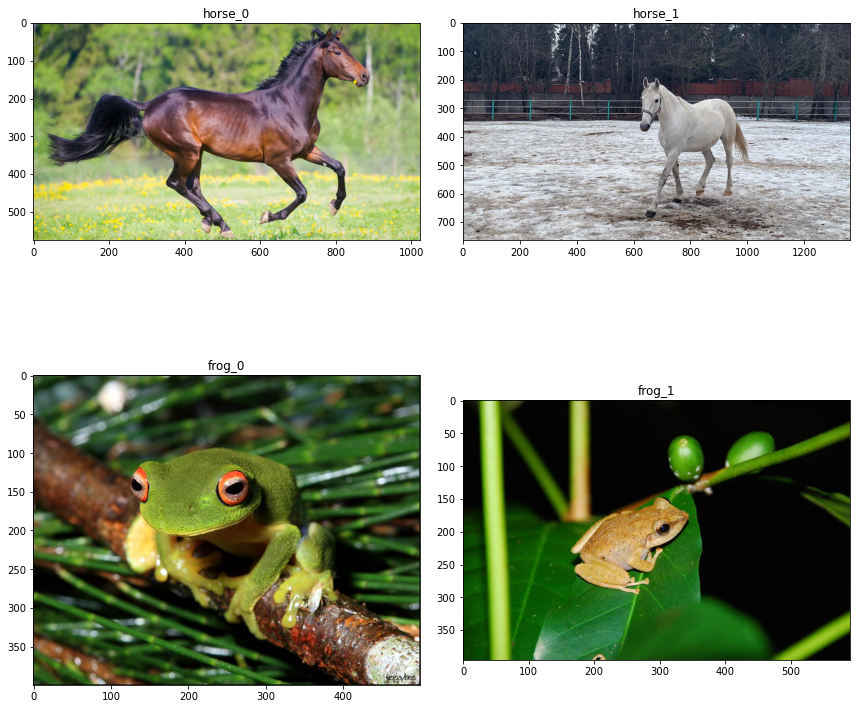

In [4]:
width=12
height=12
rows = 2
cols = 2
axes=[]
fig=plt.figure(figsize = (height,width))
datasets = [dataset_horses,dataset_frogs]
names = ['horse' ,'frog']
for row in range(rows):
    for col in range(cols):
        disp_image = datasets[row].__getitem__(col,False)
        axes.append( fig.add_subplot(rows, cols, col+1+2*row ))
        subplot_title=(names[row] + "_" + str(col))
        axes[-1].set_title(subplot_title)  
        plt.imshow(disp_image)
fig.tight_layout()    
plt.show()

### section 1.2

In [5]:
model = getModelDeepLabV3()

Using cache found in C:\Users\notov/.cache\torch\hub\pytorch_vision_v0.5.0


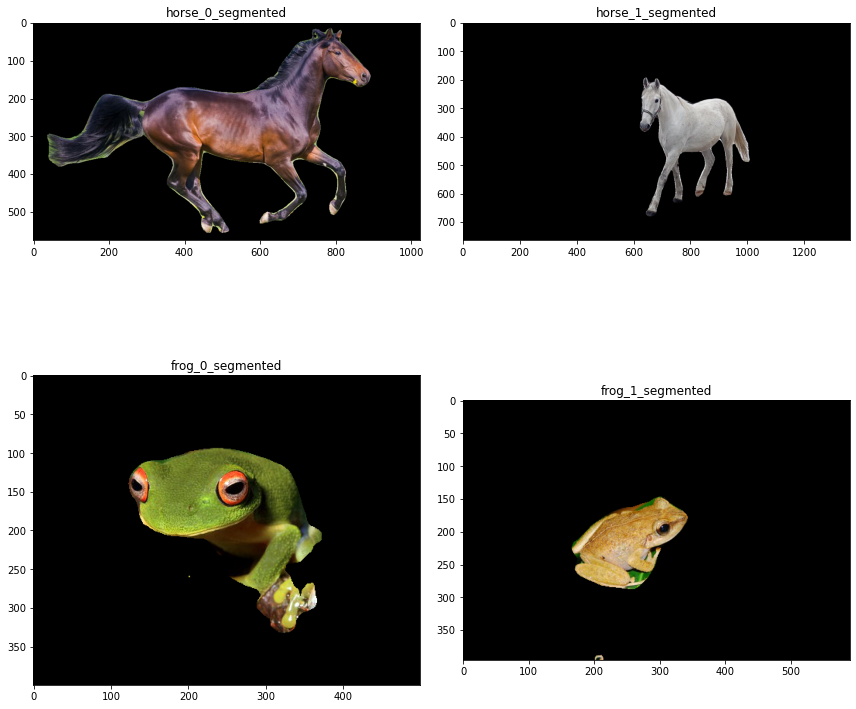

In [6]:
transform_tensor = GetTransform_tensor()
axes=[]
fig=plt.figure(figsize = (height,width))
for row in range(rows):
    for col in range(cols):
        orig_image = datasets[row].__getitem__(col,True)
        orig_image_show = datasets[row].__getitem__(col,False)
        mask = segmentImages(orig_image,model)
        #print(mask.max())
        
        mask[mask != 0] = 1
        
        orig_image_show = transform_tensor(orig_image_show)
        masked_image = mask * orig_image_show.to(device)
        masked_image = masked_image.cpu().numpy()
        
        #----
        mask = mask.cpu().numpy()
        axes.append( fig.add_subplot(rows, cols, col+1+2*row ))
        subplot_title=(names[row] + "_" + str(col) + "_segmented")
        axes[-1].set_title(subplot_title)  
        plt.imshow((255*masked_image).transpose(1,2,0).astype(np.uint8))

fig.tight_layout()    
plt.show()        

In [7]:
# TODO sarah --> use classic


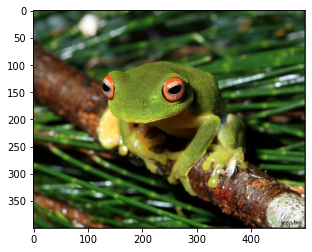

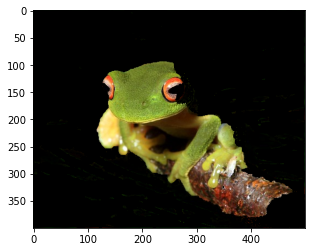

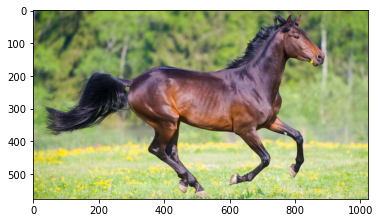

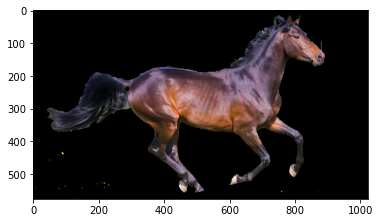

In [8]:
# Classic Method - GrabCut

#Load the Image
im = cv2.imread('data//frogs//frog1.jpg')
height, width = im.shape[:2]
plt.figure()
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

#Create a mask holder
mask = np.zeros(im.shape[:2],np.uint8)

#Grab Cut the object
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

# define a rectangular that the object lie within
rect = (10,10,width-30,height-30)
cv2.grabCut(im,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img1 = im*mask[:,:,np.newaxis]

#Get the background
background = im - img1

#Change all pixels in the background that are not black to white
background[np.where((background > [0,0,0]).all(axis = 2))] =[0,0,0]

#Add the background and the image
final = background + img1

#Result
plt.figure()
plt.imshow(cv2.cvtColor(final, cv2.COLOR_BGR2RGB))
plt.show()

im = cv2.imread('data//horses//horse1.png')
height, width = im.shape[:2]
plt.figure()
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

#Create a mask holder
mask = np.zeros(im.shape[:2],np.uint8)

#Grab Cut the object
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

# define a rectangular that the object lie within
rect = (10,10,width-30,height-30)
cv2.grabCut(im,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img1 = im*mask[:,:,np.newaxis]

#Get the background
background = im - img1

#Change all pixels in the background that are not black to white
background[np.where((background > [0,0,0]).all(axis = 2))] =[0,0,0]

#Add the background and the image
final = background + img1

#Result
plt.figure()
plt.imshow(cv2.cvtColor(final, cv2.COLOR_BGR2RGB))
plt.show()

In [9]:
''' Classic Method 1 - Improved GrabCut '''

def histogram_equalize_bgr(img):
    b, g, r = cv2.split(img)
    red = cv2.equalizeHist(r)
    green = cv2.equalizeHist(g)
    blue = cv2.equalizeHist(b)
    return cv2.merge((blue, green, red))

def myGrabCut(im):
    height, width = im.shape[:2]
    #Preprocessing
    eqim = histogram_equalize_bgr(im)
    #Create a mask holder
    mask = np.zeros(eqim.shape[:2],np.uint8)
    #Grab Cut the object
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    # define a rectangular that the object lie within
    rect = (10,10,width-30,height-30)
    cv2.grabCut(eqim,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
    mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img1 = im*mask[:,:,np.newaxis]
    #Get the background
    background = im - img1
    #Change all pixels in the background that are not black to white
    background[np.where((background > [0,0,0]).all(axis = 2))] =[0,0,0]
    #Add the background and the image
    return background + img1

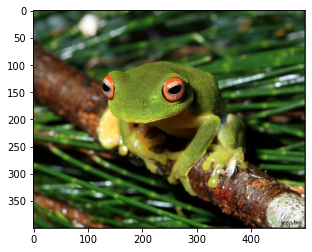

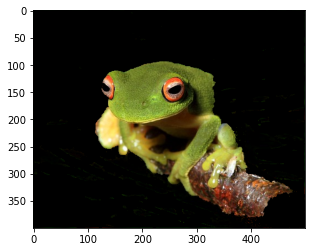

In [10]:
im = cv2.imread('data//frogs//frog1.jpg')
segment = myGrabCut(im)
  
#Result
plt.figure()
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()
    
plt.figure()
plt.imshow(cv2.cvtColor(segment, cv2.COLOR_BGR2RGB))
plt.show()


### section 1.3 + 1.4

In [11]:
my_dataset = ImageDataSet(image_folder = 'my_data')

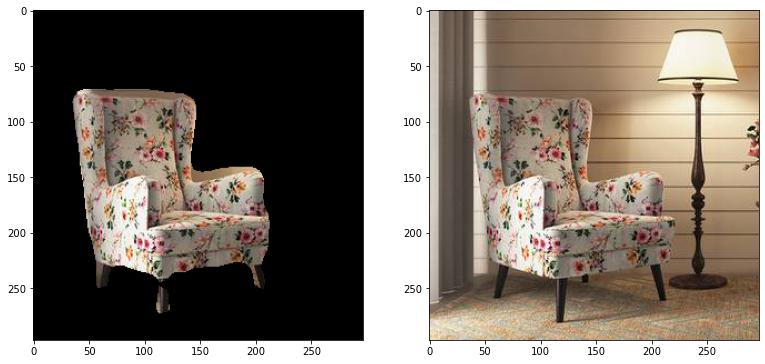

In [12]:
fig=plt.figure(figsize = (13,13))

axes=[fig.add_subplot(1,2, 1 ),fig.add_subplot(1,2, 2 )]
#seg_result = transformSegmentedToImg(segmentImages(my_dataset[0],model),my_dataset.__getitem__(0,False))
mask= segmentImages(my_dataset[0],model)
mask[mask != 0] = 1
orig_image = transform_tensor( my_dataset.__getitem__(0,False)).to(device)
masked_im = orig_image*mask
masked_im = masked_im.cpu().numpy()


axes[0].imshow((255*masked_im).transpose(1,2,0).astype(np.uint8))
axes[1].imshow(my_dataset.__getitem__(0,False))
#fig.tight_layout()    
plt.show()    

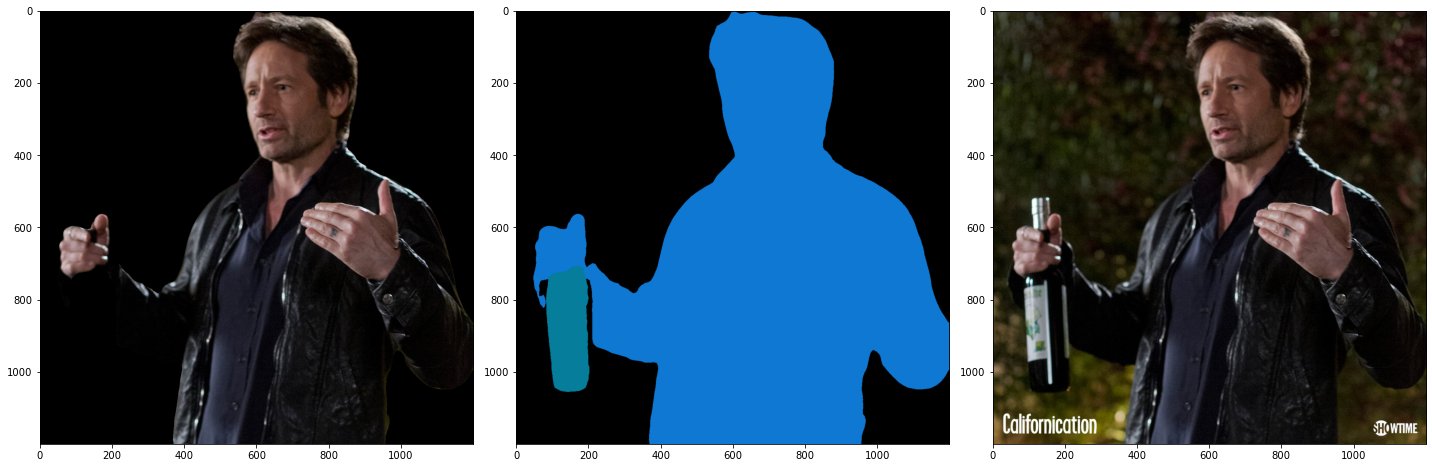

In [13]:
fig=plt.figure(figsize = (20,20))

axes=[fig.add_subplot(1,3, 1 ),fig.add_subplot(1,3, 2 ),fig.add_subplot(1,3, 3 )]
mask= segmentImages(my_dataset[1],model)
mask[mask == 15] = 1
mask[mask != 1] = 0
orig_image = transform_tensor( my_dataset.__getitem__(1,False)).to(device)
masked_im = orig_image*mask
masked_im = masked_im.cpu().numpy()
seg_result = transformSegmentedToImg(segmentImages(my_dataset[1],model),my_dataset.__getitem__(1,False))


axes[0].imshow((255*masked_im).transpose(1,2,0).astype(np.uint8))
axes[2].imshow(my_dataset.__getitem__(1,False))
axes[1].imshow(seg_result)
fig.tight_layout()    
plt.show()    

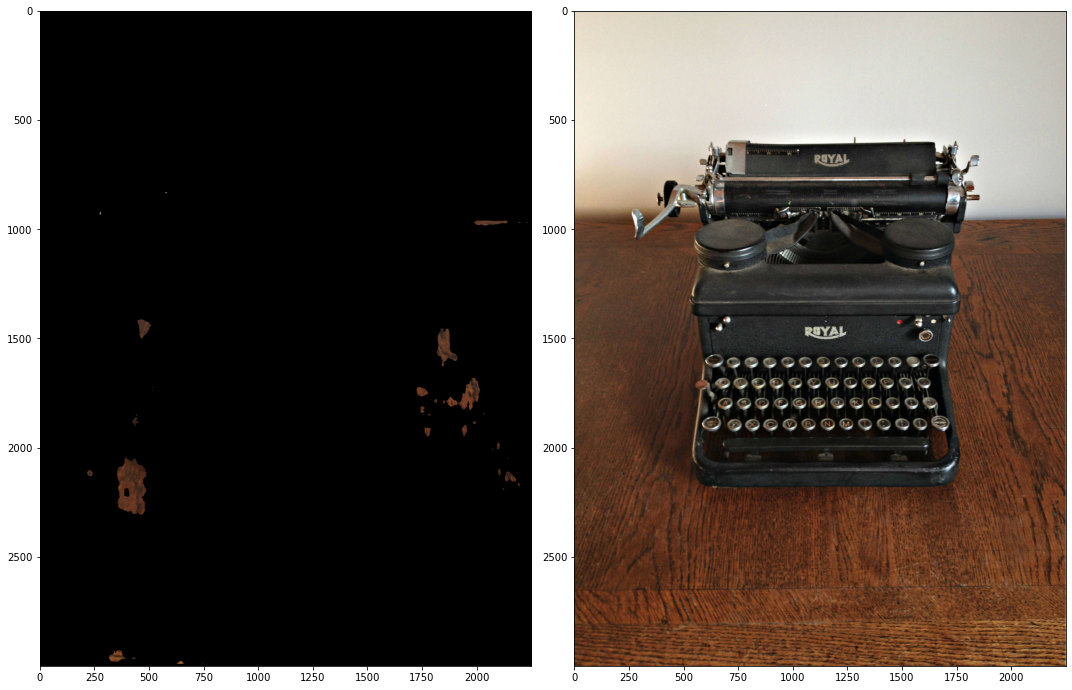

In [14]:
fig=plt.figure(figsize = (15,15))

axes=[fig.add_subplot(1,2, 1 ),fig.add_subplot(1,2, 2 )]
mask= segmentImages(my_dataset[2],model)
mask[mask != 0] = 1
orig_image = transform_tensor( my_dataset.__getitem__(2,False)).to(device)
masked_im = orig_image*mask
masked_im = masked_im.cpu().numpy()


axes[0].imshow((255*masked_im).transpose(1,2,0).astype(np.uint8))
axes[1].imshow(my_dataset.__getitem__(2,False))
fig.tight_layout()    
plt.show()    

## Classic method GrabCut

<Figure size 1080x1080 with 0 Axes>

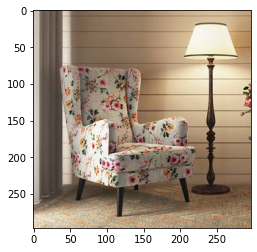

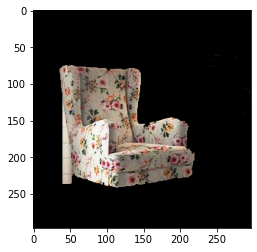

In [15]:
#Load the Image
fig=plt.figure(figsize = (15,15))
im = cv2.imread('my_data//chair.jpg')
segment = myGrabCut(im)
  
#Result
plt.figure()
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()
    
plt.figure()
plt.imshow(cv2.cvtColor(segment, cv2.COLOR_BGR2RGB))
plt.show()


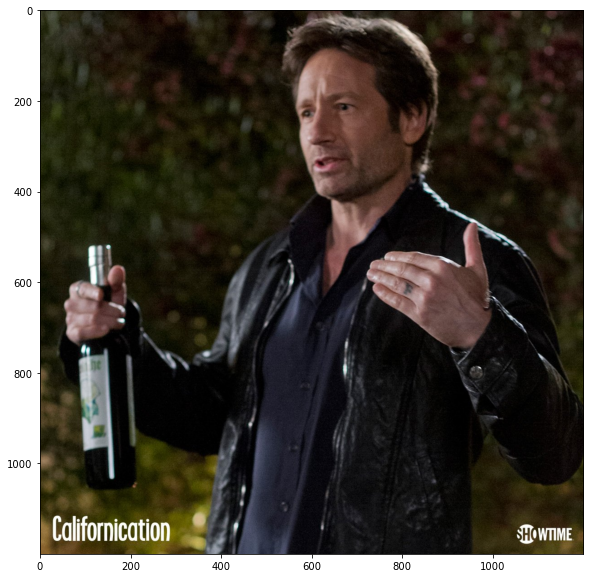

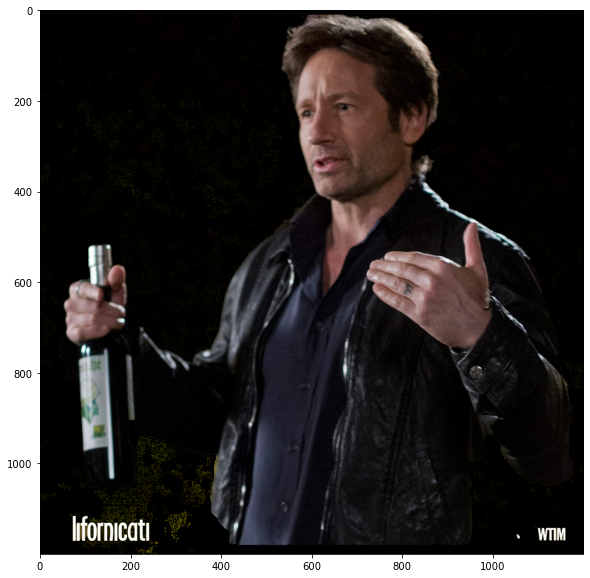

In [16]:
#Load the Image
im = cv2.imread('my_data//hank_moody.jpg')
segment = myGrabCut(im)
  
#Result
plt.figure(figsize = (10,10))
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()
    
plt.figure(figsize =(10,10))
plt.imshow(cv2.cvtColor(segment, cv2.COLOR_BGR2RGB))
plt.show()

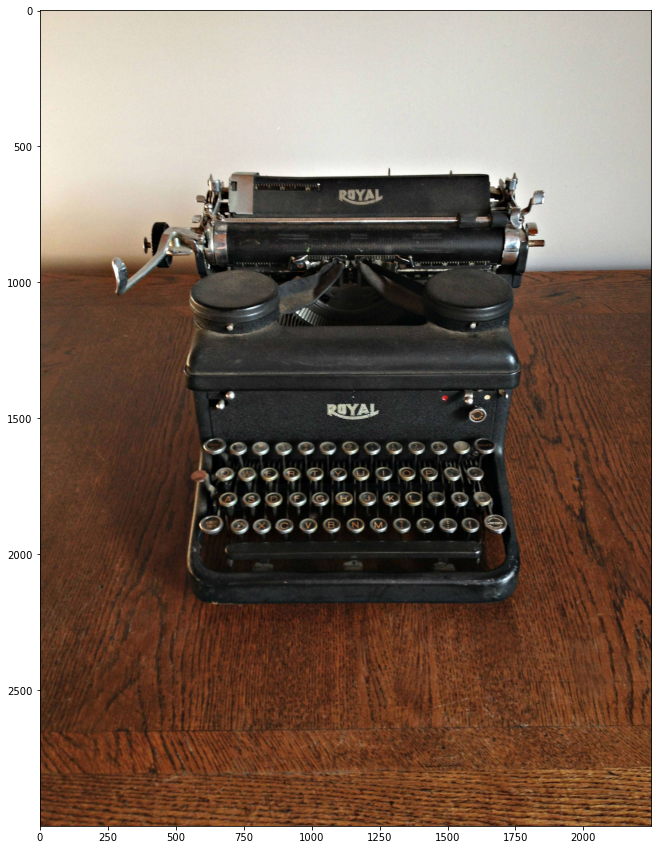

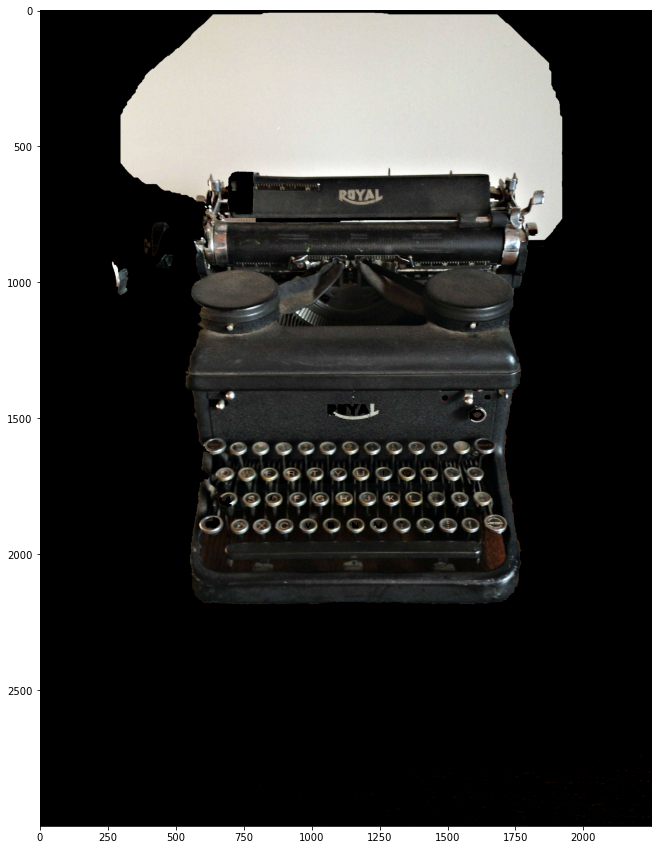

In [17]:
#Load the Image
im = cv2.imread('my_data//typing_machine.jpg')
segment = myGrabCut(im)
  
#Result
plt.figure(figsize = (15,15))
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()
    
plt.figure(figsize = (15,15))
plt.imshow(cv2.cvtColor(segment, cv2.COLOR_BGR2RGB))
plt.show()

### section 1.5


In [18]:
transform = GetTransform_data()

In [19]:
# im1 = my_dataset.__getitem__(0,False) 

# transform_tensor = GetTransform_tensor()
# im2 = im1.filter(ImageFilter.GaussianBlur(radius = 1.3))

# im2_tensor = transform(im2)
#
# mask = segmentImages(im2_tensor,model)
# mask[mask != 9] = 0

# mask[mask == 9] = 1

# fig=plt.figure(figsize = (height,width))

# masked_chair = mask * transform_tensor(im1).to(device)
# masked_chair_np = masked_chair.cpu().numpy()
# axes=[fig.add_subplot(1,2, 1 ),fig.add_subplot(1,2, 2 )]
# seg_result = transformSegmentedToImg(segmentImages(trans(im2).to(device) ,model),im2)
# axes[0].imshow((255*masked_chair_np).transpose(1,2,0).astype(np.uint8))
# axes[1].imshow(im2)
# fig.tight_layout()    
# plt.show()    

### section 1.6 + 1.7


In [20]:
classifier = getClassifier()

image = dataset_frogs[0]

In [22]:
res,probs = classify(classifier , image)
labels = json.load(open('my_data//imagenet_class_index.json'))
labels[str(res.cpu().numpy())][1]

'tree_frog'

In [23]:
dataset = ImageDataSet(image_folder = 'data')
# dataset.__getstr__('cow.jpg')
res,probs = classify(classifier , dataset.__getstr__('sheep.jpg'))
labels[str(res.cpu().numpy())][1]

'ram'

## section 1.7

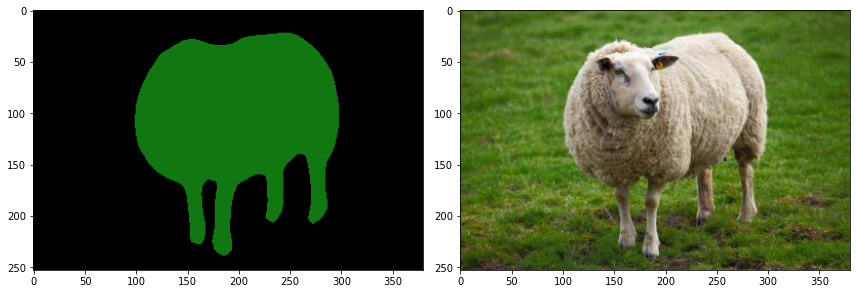

In [24]:
mask = segmentImages(dataset.__getstr__('sheep.jpg'),model)
fig=plt.figure(figsize = (12,12))

axes=[fig.add_subplot(1,2, 1 ),fig.add_subplot(1,2, 2 )]
seg_result = transformSegmentedToImg(mask ,dataset.__getstr__('sheep.jpg',False))
axes[0].imshow(seg_result)
axes[1].imshow(dataset.__getstr__('sheep.jpg',False))
fig.tight_layout()    
plt.show()    

In [25]:
def GetTransform_tensor():
    '''
    get transformations
    ''' 
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())        
    return torchvision.transforms.Compose(custom_transforms)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   
t = GetTransform_tensor()
sheep = t(dataset.__getstr__('sheep.jpg',False)).to(device)
mask[mask != 0] = 1
masked_sheep = mask * sheep
masked_sheep_np = masked_sheep.cpu().numpy()

### 1.8-1.10

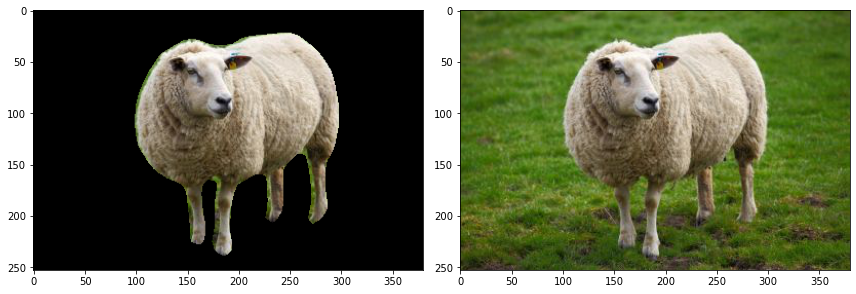

In [27]:
fig=plt.figure(figsize = (12,12))

axes=[fig.add_subplot(1,2, 1 ),fig.add_subplot(1,2, 2 )]
axes[0].imshow((255*masked_sheep_np).transpose(1,2,0).astype(np.uint8))
axes[1].imshow(dataset.__getstr__('sheep.jpg',False))
fig.tight_layout()    
plt.show()    

In [28]:
#masked_sheep.transpose(1,2,0)

masked_sheep = masked_sheep.cpu()
beach = t(dataset.__getstr__('beach.jpg',False)).cpu()
spacial_sheep = masked_sheep.shape[1],masked_sheep.shape[2]
spacial_beach = beach.shape[1],beach.shape[2]
beach[:,55:spacial_sheep[0]+55,55:spacial_sheep[1]+55][masked_sheep != 0] = 0
beach[:,55:spacial_sheep[0]+55,55:spacial_sheep[1]+55] += masked_sheep 
beach_sheep = beach.cpu().numpy()

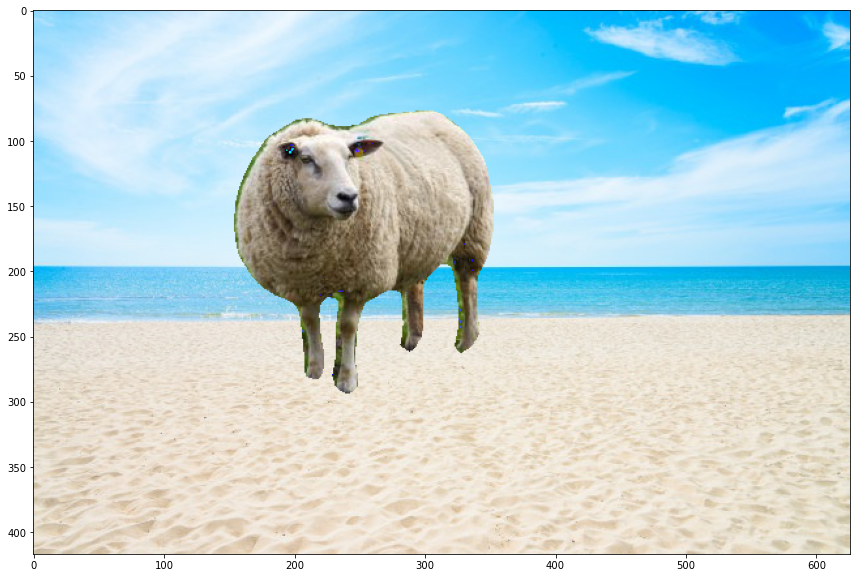

In [29]:
fig=plt.figure(figsize = (12,12))
axes=[fig.add_subplot(1,1, 1 )]
axes[0].imshow((255*beach_sheep.transpose(1,2,0)).astype(np.uint8))
fig.tight_layout()    
plt.show()    

In [30]:

res,probs = classify(classifier , beach)
labels[str(res.cpu().numpy())][1]

'sandbar'

In [31]:
cv2.imwrite('..//output//beach_sheep.jpg',cv2.cvtColor((255*beach_sheep.transpose(1,2,0)).astype(np.uint8), cv2.COLOR_RGB2BGR) )

True

In [42]:
torch.topk(probs, 3)

torch.return_types.topk(
values=tensor([[0.0582, 0.0196, 0.0150]], device='cuda:0'),
indices=tensor([[977, 978, 348]], device='cuda:0'))

In [ ]:
# refs
# https://towardsdatascience.com/background-matting-the-world-is-your-green-screen-83a3c4f0f635
# http://yaksoy.github.io/papers/TOG16-keying.pdf
# https://www.youtube.com/watch?v=KkufK8D4PwY&list=PLuh62Q4Sv7BUJlKlt84HFqSWfW36MDd5a&index=2
# https://www.youtube.com/watch?v=ZF-3aORwEc0&list=PLuh62Q4Sv7BUf60vkjePfcOQc8sHxmnDX&index=13
# https://www.youtube.com/watch?v=Mvd93DdgqAY&list=PLuh62Q4Sv7BUJlKlt84HFqSWfW36MDd5a&index=3
# https://www.youtube.com/watch?v=lYQQ88nzxAM&list=PLuh62Q4Sv7BUJlKlt84HFqSWfW36MDd5a&index=5
# https://www.youtube.com/watch?v=g7zFl8EnbzI&list=PLuh62Q4Sv7BUJlKlt84HFqSWfW36MDd5a&index=6
# https://www.youtube.com/watch?v=UcTJDamstdk